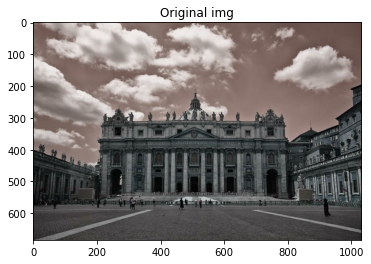

theta: 43.113851747326464
R:
[[ 0.98675546 -0.05831507 -0.15137047]
 [-0.05831507  0.74324161 -0.66647675]
 [ 0.15137047  0.66647675  0.72999707]]
R:
[[ 0.98675546 -0.05831507 -0.15137047]
 [-0.05831507  0.74324161 -0.66647675]
 [ 0.15137047  0.66647675  0.72999707]]
K:
[[839.76184082, 0.0, 516.0], [0.0, 839.76184082, 342.0], [0.0, 0.0, 1.0]],
R:
[[ 0.98675546 -0.05831507 -0.15137047]
 [-0.05831507  0.74324161 -0.66647675]
 [ 0.15137047  0.66647675  0.72999707]],
K_inv: [[ 0.00119081  0.         -0.61445993]
 [ 0.          0.00119081 -0.40725832]
 [ 0.          0.          1.        ]]
original P:
[[ 1.07976655e+00  3.51208187e-01 -4.27709396e+02]
 [ 3.33181448e-03  1.01466982e+00 -6.58759040e+02]
 [ 1.80254048e-04  7.93649723e-04  3.65557774e-01]]
K:
[[839.76184082, 0.0, 516.0], [0.0, 839.76184082, 342.0], [0.0, 0.0, 1.0]],
R:
[[ 0.98675546 -0.05831507 -0.15137047]
 [-0.05831507  0.74324161 -0.66647675]
 [ 0.15137047  0.66647675  0.72999707]],
K_inv: [[ 0.00119081  0.         -0.61445

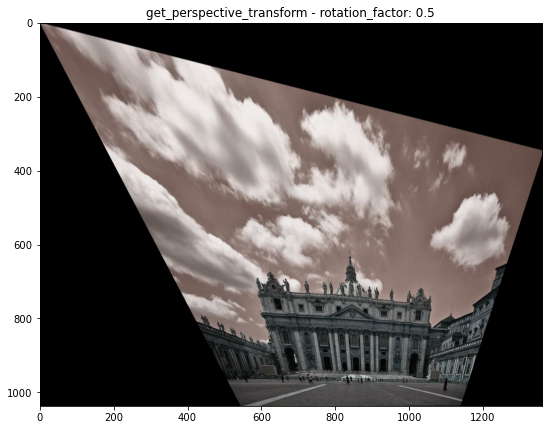

theta: 47.42523692205911
R:
[[ 0.98413378 -0.06985817 -0.1630967 ]
 [-0.06985817  0.69241789 -0.71810674]
 [ 0.1630967   0.71810674  0.67655168]]
R:
[[ 0.98413378 -0.06985817 -0.1630967 ]
 [-0.06985817  0.69241789 -0.71810674]
 [ 0.1630967   0.71810674  0.67655168]]
K:
[[839.76184082, 0.0, 516.0], [0.0, 839.76184082, 342.0], [0.0, 0.0, 1.0]],
R:
[[ 0.98413378 -0.06985817 -0.1630967 ]
 [-0.06985817  0.69241789 -0.71810674]
 [ 0.1630967   0.71810674  0.67655168]],
K_inv: [[ 0.00119081  0.         -0.61445993]
 [ 0.          0.00119081 -0.40725832]
 [ 0.          0.          1.        ]]
original P:
[[ 1.08435017e+00  3.71389645e-01 -4.74401661e+02]
 [-3.43568603e-03  9.84872843e-01 -7.06711666e+02]
 [ 1.94217798e-04  8.55131430e-04  2.83880344e-01]]
K:
[[839.76184082, 0.0, 516.0], [0.0, 839.76184082, 342.0], [0.0, 0.0, 1.0]],
R:
[[ 0.98413378 -0.06985817 -0.1630967 ]
 [-0.06985817  0.69241789 -0.71810674]
 [ 0.1630967   0.71810674  0.67655168]],
K_inv: [[ 0.00119081  0.         -0.614459

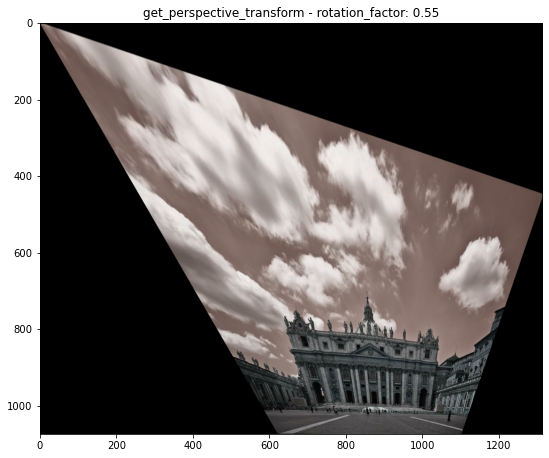

theta: 51.73662209679176
R:
[[ 0.98132428 -0.08222826 -0.17389986]
 [-0.08222826  0.63795301 -0.76567256]
 [ 0.17389986  0.76567256  0.61927729]]
R:
[[ 0.98132428 -0.08222826 -0.17389986]
 [-0.08222826  0.63795301 -0.76567256]
 [ 0.17389986  0.76567256  0.61927729]]
K:
[[839.76184082, 0.0, 516.0], [0.0, 839.76184082, 342.0], [0.0, 0.0, 1.0]],
R:
[[ 0.98132428 -0.08222826 -0.17389986]
 [-0.08222826  0.63795301 -0.76567256]
 [ 0.17389986  0.76567256  0.61927729]],
K_inv: [[ 0.00119081  0.         -0.61445993]
 [ 0.          0.00119081 -0.40725832]
 [ 0.          0.          1.        ]]
original P:
[[ 1.08817878e+00  3.88246847e-01 -5.20768058e+02]
 [-1.14060926e-02  9.49779534e-01 -7.50128821e+02]
 [ 2.07082359e-04  9.11773461e-04  2.00596274e-01]]
K:
[[839.76184082, 0.0, 516.0], [0.0, 839.76184082, 342.0], [0.0, 0.0, 1.0]],
R:
[[ 0.98132428 -0.08222826 -0.17389986]
 [-0.08222826  0.63795301 -0.76567256]
 [ 0.17389986  0.76567256  0.61927729]],
K_inv: [[ 0.00119081  0.         -0.614459

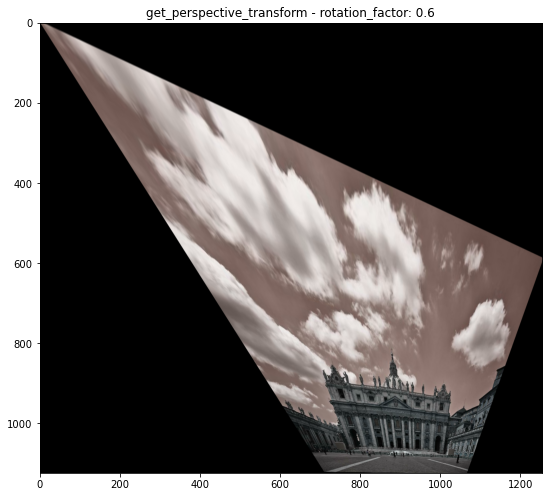

theta: 56.04800727152441
R:
[[ 0.97834286 -0.09535532 -0.18371883]
 [-0.09535532  0.58015521 -0.808905  ]
 [ 0.18371883  0.808905    0.55849807]]
R:
[[ 0.97834286 -0.09535532 -0.18371883]
 [-0.09535532  0.58015521 -0.808905  ]
 [ 0.18371883  0.808905    0.55849807]]
K:
[[839.76184082, 0.0, 516.0], [0.0, 839.76184082, 342.0], [0.0, 0.0, 1.0]],
R:
[[ 0.97834286 -0.09535532 -0.18371883]
 [-0.09535532  0.58015521 -0.808905  ]
 [ 0.18371883  0.808905    0.55849807]],
K_inv: [[ 0.00119081  0.         -0.61445993]
 [ 0.          0.00119081 -0.40725832]
 [ 0.          0.          1.        ]]
original P:
[[ 1.09123072e+00  4.01684387e-01 -5.66546174e+02]
 [-2.05342961e-02  9.09588502e-01 -7.88764782e+02]
 [ 2.18774923e-04  9.63255247e-04  1.16176914e-01]]
K:
[[839.76184082, 0.0, 516.0], [0.0, 839.76184082, 342.0], [0.0, 0.0, 1.0]],
R:
[[ 0.97834286 -0.09535532 -0.18371883]
 [-0.09535532  0.58015521 -0.808905  ]
 [ 0.18371883  0.808905    0.55849807]],
K_inv: [[ 0.00119081  0.         -0.614459

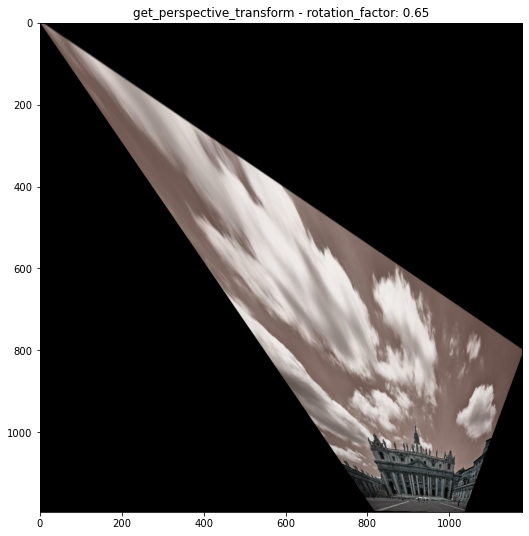

theta: 60.35939244625705
R:
[[ 0.97520639 -0.10916506 -0.19249803]
 [-0.10916506  0.5193516  -0.84755938]
 [ 0.19249803  0.84755938  0.49455798]]
R:
[[ 0.97520639 -0.10916506 -0.19249803]
 [-0.10916506  0.5193516  -0.84755938]
 [ 0.19249803  0.84755938  0.49455798]]
K:
[[839.76184082, 0.0, 516.0], [0.0, 839.76184082, 342.0], [0.0, 0.0, 1.0]],
R:
[[ 0.97520639 -0.10916506 -0.19249803]
 [-0.10916506  0.5193516  -0.84755938]
 [ 0.19249803  0.84755938  0.49455798]],
K_inv: [[ 0.00119081  0.         -0.61445993]
 [ 0.          0.00119081 -0.40725832]
 [ 0.          0.          1.        ]]
original P:
[[ 1.09348871e+00  4.11626217e-01 -6.11476924e+02]
 [-3.07686348e-02  8.64527211e-01 -8.22400888e+02]
 [ 2.29229315e-04  1.00928542e-03  3.11000438e-02]]
K:
[[839.76184082, 0.0, 516.0], [0.0, 839.76184082, 342.0], [0.0, 0.0, 1.0]],
R:
[[ 0.97520639 -0.10916506 -0.19249803]
 [-0.10916506  0.5193516  -0.84755938]
 [ 0.19249803  0.84755938  0.49455798]],
K_inv: [[ 0.00119081  0.         -0.614459

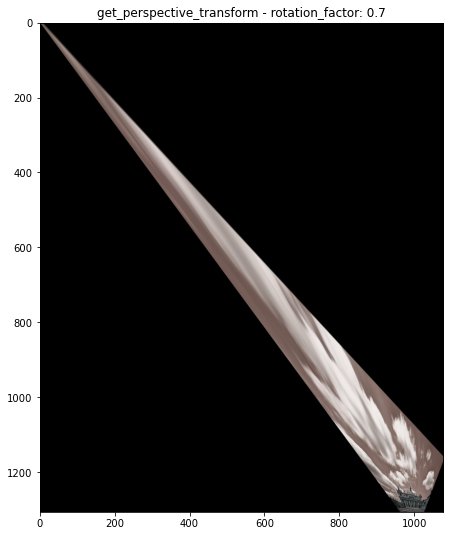

theta: 64.6707776209897
R:
[[ 0.97193261 -0.12357932 -0.20018778]
 [-0.12357932  0.4558863  -0.88141695]
 [ 0.20018778  0.88141695  0.42781891]]
R:
[[ 0.97193261 -0.12357932 -0.20018778]
 [-0.12357932  0.4558863  -0.88141695]
 [ 0.20018778  0.88141695  0.42781891]]
K:
[[839.76184082, 0.0, 516.0], [0.0, 839.76184082, 342.0], [0.0, 0.0, 1.0]],
R:
[[ 0.97193261 -0.12357932 -0.20018778]
 [-0.12357932  0.4558863  -0.88141695]
 [ 0.20018778  0.88141695  0.42781891]],
K_inv: [[ 0.00119081  0.         -0.61445993]
 [ 0.          0.00119081 -0.40725832]
 [ 0.          0.          1.        ]]
original P:
[[ 1.09493998e+00  4.18016068e-01 -6.55306019e+02]
 [-4.20511869e-02  8.14850689e-01 -8.50846771e+02]
 [ 2.38386368e-04  1.04960347e-03 -5.41528398e-02]]
K:
[[839.76184082, 0.0, 516.0], [0.0, 839.76184082, 342.0], [0.0, 0.0, 1.0]],
R:
[[ 0.97193261 -0.12357932 -0.20018778]
 [-0.12357932  0.4558863  -0.88141695]
 [ 0.20018778  0.88141695  0.42781891]],
K_inv: [[ 0.00119081  0.         -0.6144599

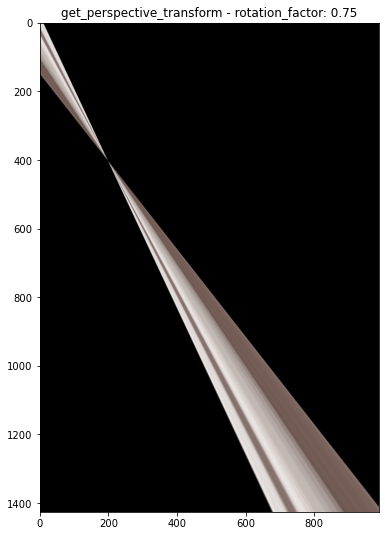

theta: 68.98216279572236
R:
[[ 0.96854007 -0.13851653 -0.20674454]
 [-0.13851653  0.3901185  -0.91028607]
 [ 0.20674454  0.91028607  0.35865857]]
R:
[[ 0.96854007 -0.13851653 -0.20674454]
 [-0.13851653  0.3901185  -0.91028607]
 [ 0.20674454  0.91028607  0.35865857]]
K:
[[839.76184082, 0.0, 516.0], [0.0, 839.76184082, 342.0], [0.0, 0.0, 1.0]],
R:
[[ 0.96854007 -0.13851653 -0.20674454]
 [-0.13851653  0.3901185  -0.91028607]
 [ 0.20674454  0.91028607  0.35865857]],
K_inv: [[ 0.00119081  0.         -0.61445993]
 [ 0.          0.00119081 -0.40725832]
 [ 0.          0.          1.        ]]
original P:
[[ 1.09557630e+00  4.20817777e-01 -6.97785406e+02]
 [-5.43180979e-02  7.60840082e-01 -8.73941441e+02]
 [ 2.46194256e-04  1.08398122e-03 -1.39099242e-01]]
K:
[[839.76184082, 0.0, 516.0], [0.0, 839.76184082, 342.0], [0.0, 0.0, 1.0]],
R:
[[ 0.96854007 -0.13851653 -0.20674454]
 [-0.13851653  0.3901185  -0.91028607]
 [ 0.20674454  0.91028607  0.35865857]],
K_inv: [[ 0.00119081  0.         -0.614459

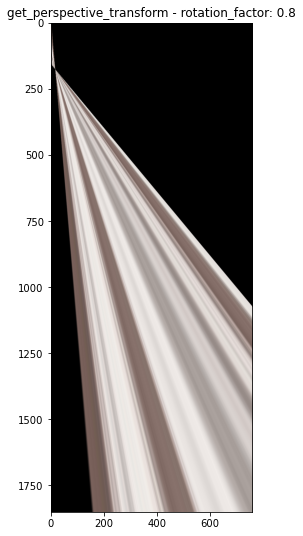

theta: 73.29354797045501
R:
[[ 0.96504795 -0.15389215 -0.21213122]
 [-0.15389215  0.32242042 -0.93400336]
 [ 0.21213122  0.93400336  0.28746838]]
R:
[[ 0.96504795 -0.15389215 -0.21213122]
 [-0.15389215  0.32242042 -0.93400336]
 [ 0.21213122  0.93400336  0.28746838]]
K:
[[839.76184082, 0.0, 516.0], [0.0, 839.76184082, 342.0], [0.0, 0.0, 1.0]],
R:
[[ 0.96504795 -0.15389215 -0.21213122]
 [-0.15389215  0.32242042 -0.93400336]
 [ 0.21213122  0.93400336  0.28746838]],
K_inv: [[ 0.00119081  0.         -0.61445993]
 [ 0.          0.00119081 -0.40725832]
 [ 0.          0.          1.        ]]
original P:
[[ 1.09539409e+00  4.20015488e-01 -7.38674670e+02]
 [-6.74999423e-02  7.02801068e-01 -8.91554191e+02]
 [ 2.52608790e-04  1.11222410e-03 -2.23258401e-01]]
K:
[[839.76184082, 0.0, 516.0], [0.0, 839.76184082, 342.0], [0.0, 0.0, 1.0]],
R:
[[ 0.96504795 -0.15389215 -0.21213122]
 [-0.15389215  0.32242042 -0.93400336]
 [ 0.21213122  0.93400336  0.28746838]],
K_inv: [[ 0.00119081  0.         -0.614459

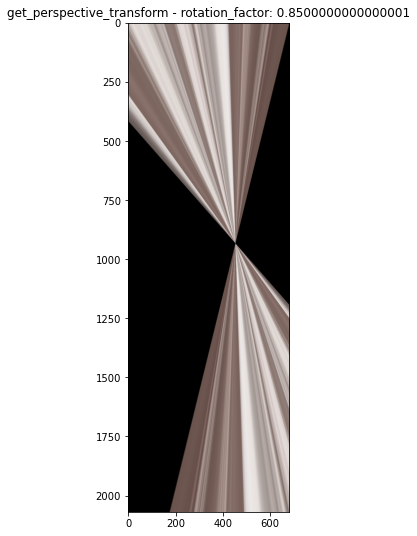

theta: 77.60493314518766
R:
[[ 0.96147603 -0.16961915 -0.21631733]
 [-0.16961915  0.25317521 -0.9524346 ]
 [ 0.21631733  0.9524346   0.21465124]]
R:
[[ 0.96147603 -0.16961915 -0.21631733]
 [-0.16961915  0.25317521 -0.9524346 ]
 [ 0.21631733  0.9524346   0.21465124]]
K:
[[839.76184082, 0.0, 516.0], [0.0, 839.76184082, 342.0], [0.0, 0.0, 1.0]],
R:
[[ 0.96147603 -0.16961915 -0.21631733]
 [-0.16961915  0.25317521 -0.9524346 ]
 [ 0.21631733  0.9524346   0.21465124]],
K_inv: [[ 0.00119081  0.         -0.61445993]
 [ 0.          0.00119081 -0.40725832]
 [ 0.          0.          1.        ]]
original P:
[[ 1.09439436e+00  4.15613742e-01 -7.77742395e+02]
 [-8.15221166e-02  6.41062123e-01 -9.03585341e+02]
 [ 2.57593668e-04  1.13417227e-03 -3.06154015e-01]]
K:
[[839.76184082, 0.0, 516.0], [0.0, 839.76184082, 342.0], [0.0, 0.0, 1.0]],
R:
[[ 0.96147603 -0.16961915 -0.21631733]
 [-0.16961915  0.25317521 -0.9524346 ]
 [ 0.21631733  0.9524346   0.21465124]],
K_inv: [[ 0.00119081  0.         -0.614459

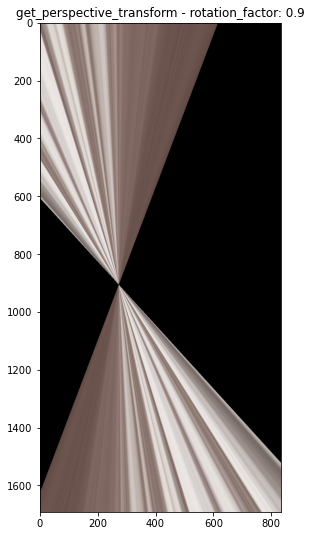

theta: 81.91631831992028
R:
[[ 0.95784451 -0.18560853 -0.21927918]
 [-0.18560853  0.18277474 -0.96547546]
 [ 0.21927918  0.96547546  0.14061926]]
R:
[[ 0.95784451 -0.18560853 -0.21927918]
 [-0.18560853  0.18277474 -0.96547546]
 [ 0.21927918  0.96547546  0.14061926]]
K:
[[839.76184082, 0.0, 516.0], [0.0, 839.76184082, 342.0], [0.0, 0.0, 1.0]],
R:
[[ 0.95784451 -0.18560853 -0.21927918]
 [-0.18560853  0.18277474 -0.96547546]
 [ 0.21927918  0.96547546  0.14061926]],
K_inv: [[ 0.00119081  0.         -0.61445993]
 [ 0.          0.00119081 -0.40725832]
 [ 0.          0.          1.        ]]
original P:
[[ 1.09258278e+00  4.07637450e-01 -8.14767473e+02]
 [-9.63052613e-02  5.75972663e-01 -9.09966799e+02]
 [ 2.61120676e-04  1.14970152e-03 -3.87316928e-01]]
K:
[[839.76184082, 0.0, 516.0], [0.0, 839.76184082, 342.0], [0.0, 0.0, 1.0]],
R:
[[ 0.95784451 -0.18560853 -0.21927918]
 [-0.18560853  0.18277474 -0.96547546]
 [ 0.21927918  0.96547546  0.14061926]],
K_inv: [[ 0.00119081  0.         -0.614459

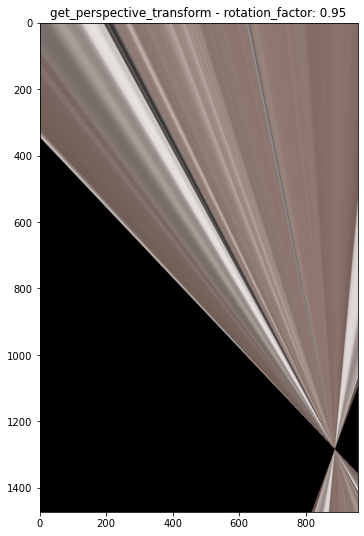

theta: 86.22770349465293
R:
[[ 0.95417396 -0.2017698  -0.221     ]
 [-0.2017698   0.11161748 -0.97305215]
 [ 0.221       0.97305215  0.06579144]]
R:
[[ 0.95417396 -0.2017698  -0.221     ]
 [-0.2017698   0.11161748 -0.97305215]
 [ 0.221       0.97305215  0.06579144]]
K:
[[839.76184082, 0.0, 516.0], [0.0, 839.76184082, 342.0], [0.0, 0.0, 1.0]],
R:
[[ 0.95417396 -0.2017698  -0.221     ]
 [-0.2017698   0.11161748 -0.97305215]
 [ 0.221       0.97305215  0.06579144]],
K_inv: [[ 0.00119081  0.         -0.61445993]
 [ 0.          0.00119081 -0.40725832]
 [ 0.          0.          1.        ]]
original P:
[[ 1.08996961e+00  3.96131754e-01 -8.49540361e+02]
 [-1.11765710e-01  5.07901065e-01 -9.10662451e+02]
 [ 2.63169853e-04  1.15872394e-03 -4.66287793e-01]]
K:
[[839.76184082, 0.0, 516.0], [0.0, 839.76184082, 342.0], [0.0, 0.0, 1.0]],
R:
[[ 0.95417396 -0.2017698  -0.221     ]
 [-0.2017698   0.11161748 -0.97305215]
 [ 0.221       0.97305215  0.06579144]],
K_inv: [[ 0.00119081  0.         -0.614459

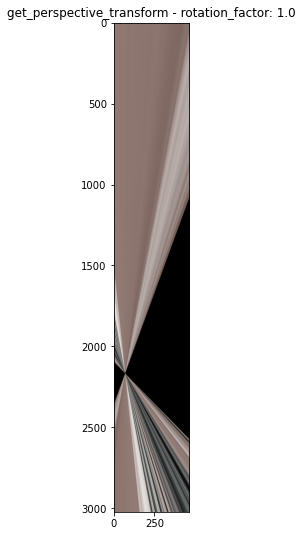

theta: 90.53908866938559
R:
[[ 0.95048514 -0.21801149 -0.22147006]
 [-0.21801149  0.04010612 -0.97512178]
 [ 0.22147006  0.97512178 -0.00940873]]
R:
[[ 0.95048514 -0.21801149 -0.22147006]
 [-0.21801149  0.04010612 -0.97512178]
 [ 0.22147006  0.97512178 -0.00940873]]
K:
[[839.76184082, 0.0, 516.0], [0.0, 839.76184082, 342.0], [0.0, 0.0, 1.0]],
R:
[[ 0.95048514 -0.21801149 -0.22147006]
 [-0.21801149  0.04010612 -0.97512178]
 [ 0.22147006  0.97512178 -0.00940873]],
K_inv: [[ 0.00119081  0.         -0.61445993]
 [ 0.          0.00119081 -0.40725832]
 [ 0.          0.          1.        ]]
original P:
[[ 1.08656962e+00  3.81161772e-01 -8.81864257e+02]
 [-1.27815964e-01  4.37232587e-01 -9.05668357e+02]
 [ 2.63729602e-04  1.16118849e-03 -5.42619671e-01]]
K:
[[839.76184082, 0.0, 516.0], [0.0, 839.76184082, 342.0], [0.0, 0.0, 1.0]],
R:
[[ 0.95048514 -0.21801149 -0.22147006]
 [-0.21801149  0.04010612 -0.97512178]
 [ 0.22147006  0.97512178 -0.00940873]],
K_inv: [[ 0.00119081  0.         -0.614459

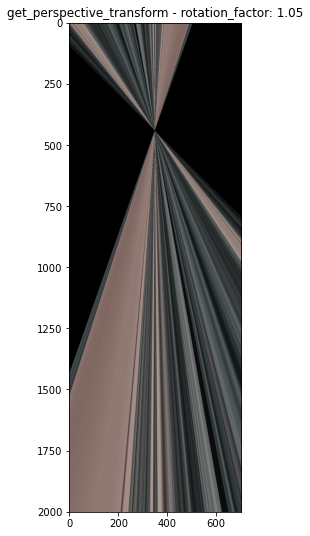

theta: 94.85047384411823
R:
[[ 0.94679894 -0.23424167 -0.22068669]
 [-0.23424167 -0.03135459 -0.97167264]
 [ 0.22068669  0.97167264 -0.08455566]]
R:
[[ 0.94679894 -0.23424167 -0.22068669]
 [-0.23424167 -0.03135459 -0.97167264]
 [ 0.22068669  0.97167264 -0.08455566]]
K:
[[839.76184082, 0.0, 516.0], [0.0, 839.76184082, 342.0], [0.0, 0.0, 1.0]],
R:
[[ 0.94679894 -0.23424167 -0.22068669]
 [-0.23424167 -0.03135459 -0.97167264]
 [ 0.22068669  0.97167264 -0.08455566]],
K_inv: [[ 0.00119081  0.         -0.61445993]
 [ 0.          0.00119081 -0.40725832]
 [ 0.          0.          1.        ]]
original P:
[[ 1.08240206e+00  3.62812228e-01 -9.11556222e+02]
 [-1.44365184e-01  3.64367181e-01 -8.95012784e+02]
 [ 2.62796754e-04  1.15708121e-03 -6.15880554e-01]]
K:
[[839.76184082, 0.0, 516.0], [0.0, 839.76184082, 342.0], [0.0, 0.0, 1.0]],
R:
[[ 0.94679894 -0.23424167 -0.22068669]
 [-0.23424167 -0.03135459 -0.97167264]
 [ 0.22068669  0.97167264 -0.08455566]],
K_inv: [[ 0.00119081  0.         -0.614459

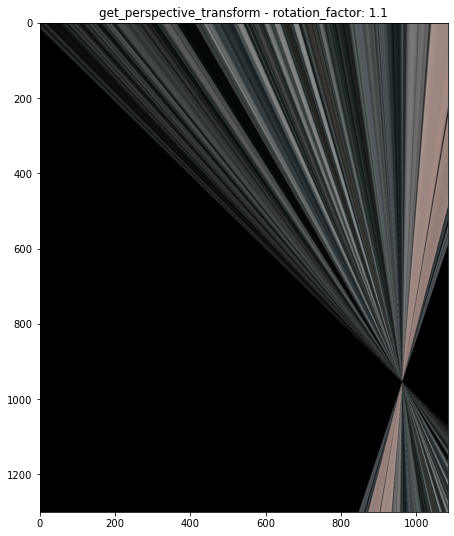

theta: 99.16185901885088
R:
[[ 0.9431362  -0.2503685  -0.21865432]
 [-0.2503685  -0.10236023 -0.96272426]
 [ 0.21865432  0.96272426 -0.15922403]]
R:
[[ 0.9431362  -0.2503685  -0.21865432]
 [-0.2503685  -0.10236023 -0.96272426]
 [ 0.21865432  0.96272426 -0.15922403]]
K:
[[839.76184082, 0.0, 516.0], [0.0, 839.76184082, 342.0], [0.0, 0.0, 1.0]],
R:
[[ 0.9431362  -0.2503685  -0.21865432]
 [-0.2503685  -0.10236023 -0.96272426]
 [ 0.21865432  0.96272426 -0.15922403]],
K_inv: [[ 0.00119081  0.         -0.61445993]
 [ 0.          0.00119081 -0.40725832]
 [ 0.          0.          1.        ]]
original P:
[[ 1.07749052e+00  3.41186973e-01 -9.38448213e+02]
 [-1.61319711e-01  2.89717234e-01 -8.78756036e+02]
 [ 2.60376590e-04  1.14642534e-03 -6.85655818e-01]]
K:
[[839.76184082, 0.0, 516.0], [0.0, 839.76184082, 342.0], [0.0, 0.0, 1.0]],
R:
[[ 0.9431362  -0.2503685  -0.21865432]
 [-0.2503685  -0.10236023 -0.96272426]
 [ 0.21865432  0.96272426 -0.15922403]],
K_inv: [[ 0.00119081  0.         -0.614459

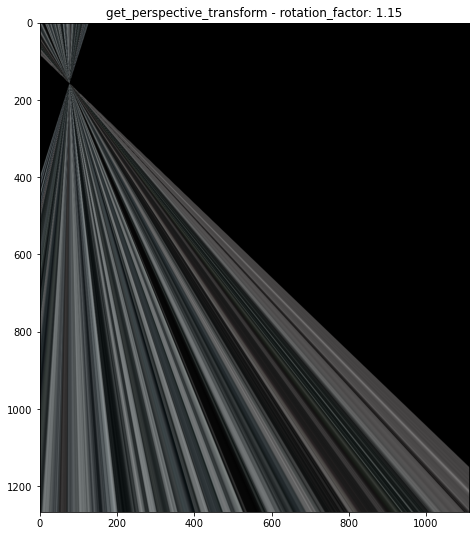

theta: 103.47324419358353
R:
[[ 0.93951768 -0.26630071 -0.21538447]
 [-0.26630071 -0.17250894 -0.94832726]
 [ 0.21538447  0.94832726 -0.23299126]]
R:
[[ 0.93951768 -0.26630071 -0.21538447]
 [-0.26630071 -0.17250894 -0.94832726]
 [ 0.21538447  0.94832726 -0.23299126]]
K:
[[839.76184082, 0.0, 516.0], [0.0, 839.76184082, 342.0], [0.0, 0.0, 1.0]],
R:
[[ 0.93951768 -0.26630071 -0.21538447]
 [-0.26630071 -0.17250894 -0.94832726]
 [ 0.21538447  0.94832726 -0.23299126]],
K_inv: [[ 0.00119081  0.         -0.61445993]
 [ 0.          0.00119081 -0.40725832]
 [ 0.          0.          1.        ]]
original P:
[[ 1.07186280e+00  3.16408395e-01 -9.62388032e+02]
 [-1.78583587e-01  2.13705233e-01 -8.56990120e+02]
 [ 2.56482807e-04  1.12928121e-03 -7.51550565e-01]]
K:
[[839.76184082, 0.0, 516.0], [0.0, 839.76184082, 342.0], [0.0, 0.0, 1.0]],
R:
[[ 0.93951768 -0.26630071 -0.21538447]
 [-0.26630071 -0.17250894 -0.94832726]
 [ 0.21538447  0.94832726 -0.23299126]],
K_inv: [[ 0.00119081  0.         -0.61445

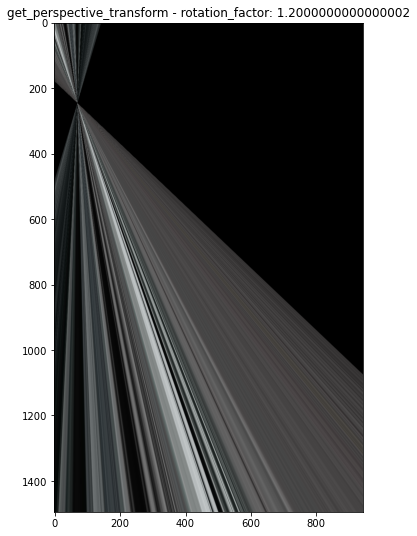

theta: 107.78462936831617
R:
[[ 0.93596383 -0.28194811 -0.21089564]
 [-0.28194811 -0.2414037  -0.92856315]
 [ 0.21089564  0.92856315 -0.30543987]]
R:
[[ 0.93596383 -0.28194811 -0.21089564]
 [-0.28194811 -0.2414037  -0.92856315]
 [ 0.21089564  0.92856315 -0.30543987]]
K:
[[839.76184082, 0.0, 516.0], [0.0, 839.76184082, 342.0], [0.0, 0.0, 1.0]],
R:
[[ 0.93596383 -0.28194811 -0.21089564]
 [-0.28194811 -0.2414037  -0.92856315]
 [ 0.21089564  0.92856315 -0.30543987]],
K_inv: [[ 0.00119081  0.         -0.61445993]
 [ 0.          0.00119081 -0.40725832]
 [ 0.          0.          1.        ]]
original P:
[[ 1.06555075e+00  2.88616731e-01 -9.83240191e+02]
 [-1.96059108e-01  1.36761373e-01 -8.29838222e+02]
 [ 2.51137441e-04  1.10574582e-03 -8.13191858e-01]]
K:
[[839.76184082, 0.0, 516.0], [0.0, 839.76184082, 342.0], [0.0, 0.0, 1.0]],
R:
[[ 0.93596383 -0.28194811 -0.21089564]
 [-0.28194811 -0.2414037  -0.92856315]
 [ 0.21089564  0.92856315 -0.30543987]],
K_inv: [[ 0.00119081  0.         -0.61445

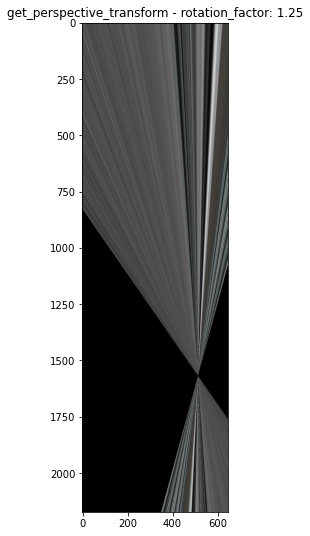

theta: 112.09601454304882
R:
[[ 0.93249478 -0.29722216 -0.20521323]
 [-0.29722216 -0.30865459 -0.90354376]
 [ 0.20521323  0.90354376 -0.37615981]]
R:
[[ 0.93249478 -0.29722216 -0.20521323]
 [-0.29722216 -0.30865459 -0.90354376]
 [ 0.20521323  0.90354376 -0.37615981]]
K:
[[839.76184082, 0.0, 516.0], [0.0, 839.76184082, 342.0], [0.0, 0.0, 1.0]],
R:
[[ 0.93249478 -0.29722216 -0.20521323]
 [-0.29722216 -0.30865459 -0.90354376]
 [ 0.20521323  0.90354376 -0.37615981]],
K_inv: [[ 0.00119081  0.         -0.61445993]
 [ 0.          0.00119081 -0.40725832]
 [ 0.          0.          1.        ]]
original P:
[[ 1.05859009e+00  2.57969270e-01 -1.00088667e+03]
 [-2.13647369e-01  5.93211228e-02 -7.97454009e+02]
 [ 2.44370744e-04  1.07595239e-03 -8.70230835e-01]]
K:
[[839.76184082, 0.0, 516.0], [0.0, 839.76184082, 342.0], [0.0, 0.0, 1.0]],
R:
[[ 0.93249478 -0.29722216 -0.20521323]
 [-0.29722216 -0.30865459 -0.90354376]
 [ 0.20521323  0.90354376 -0.37615981]],
K_inv: [[ 0.00119081  0.         -0.61445

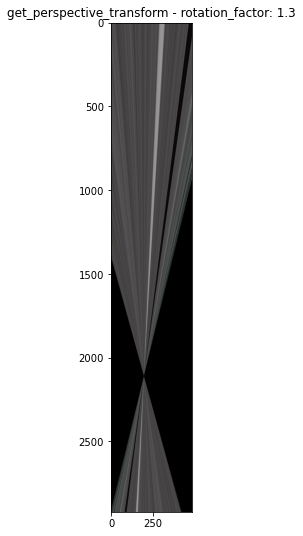

theta: 116.40739971778149
R:
[[ 0.92913016 -0.31203642 -0.19836939]
 [-0.31203642 -0.37388102 -0.8734107 ]
 [ 0.19836939  0.8734107  -0.44475086]]
R:
[[ 0.92913016 -0.31203642 -0.19836939]
 [-0.31203642 -0.37388102 -0.8734107 ]
 [ 0.19836939  0.8734107  -0.44475086]]
K:
[[839.76184082, 0.0, 516.0], [0.0, 839.76184082, 342.0], [0.0, 0.0, 1.0]],
R:
[[ 0.92913016 -0.31203642 -0.19836939]
 [-0.31203642 -0.37388102 -0.8734107 ]
 [ 0.19836939  0.8734107  -0.44475086]],
K_inv: [[ 0.00119081  0.         -0.61445993]
 [ 0.          0.00119081 -0.40725832]
 [ 0.          0.          1.        ]]
original P:
[[ 1.05102021e+00  2.24639463e-01 -1.01522761e+03]
 [-2.31248828e-01 -1.81772386e-02 -7.60020763e+02]
 [ 2.36221015e-04  1.04006953e-03 -9.22344680e-01]]
K:
[[839.76184082, 0.0, 516.0], [0.0, 839.76184082, 342.0], [0.0, 0.0, 1.0]],
R:
[[ 0.92913016 -0.31203642 -0.19836939]
 [-0.31203642 -0.37388102 -0.8734107 ]
 [ 0.19836939  0.8734107  -0.44475086]],
K_inv: [[ 0.00119081  0.         -0.61445

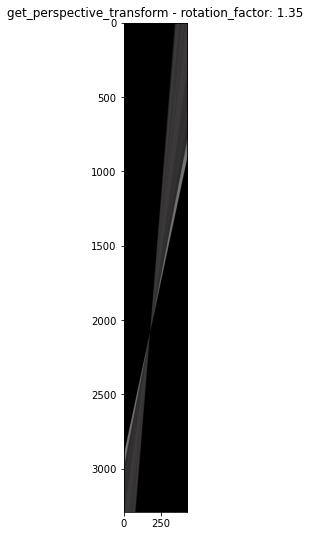

theta: 120.7187848925141
R:
[[ 0.92588902 -0.32630703 -0.19040288]
 [-0.32630703 -0.43671382 -0.83833452]
 [ 0.19040288  0.83833452 -0.5108248 ]]
R:
[[ 0.92588902 -0.32630703 -0.19040288]
 [-0.32630703 -0.43671382 -0.83833452]
 [ 0.19040288  0.83833452 -0.5108248 ]]
K:
[[839.76184082, 0.0, 516.0], [0.0, 839.76184082, 342.0], [0.0, 0.0, 1.0]],
R:
[[ 0.92588902 -0.32630703 -0.19040288]
 [-0.32630703 -0.43671382 -0.83833452]
 [ 0.19040288  0.83833452 -0.5108248 ]],
K_inv: [[ 0.00119081  0.         -0.61445993]
 [ 0.          0.00119081 -0.40725832]
 [ 0.          0.          1.        ]]
original P:
[[ 1.04288395e+00  1.88815943e-01 -1.02618184e+03]
 [-2.48763869e-01 -9.52951038e-02 -7.17750340e+02]
 [ 2.26734376e-04  9.98300327e-04 -9.69238450e-01]]
K:
[[839.76184082, 0.0, 516.0], [0.0, 839.76184082, 342.0], [0.0, 0.0, 1.0]],
R:
[[ 0.92588902 -0.32630703 -0.19040288]
 [-0.32630703 -0.43671382 -0.83833452]
 [ 0.19040288  0.83833452 -0.5108248 ]],
K_inv: [[ 0.00119081  0.         -0.614459

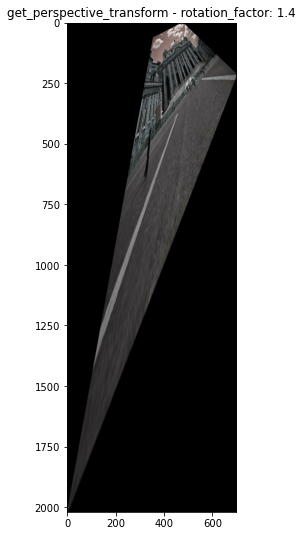

theta: 125.03017006724677
R:
[[ 0.92278968 -0.33995323 -0.18135876]
 [-0.33995323 -0.49679738 -0.79851372]
 [ 0.18135876  0.79851372 -0.5740077 ]]
R:
[[ 0.92278968 -0.33995323 -0.18135876]
 [-0.33995323 -0.49679738 -0.79851372]
 [ 0.18135876  0.79851372 -0.5740077 ]]
K:
[[839.76184082, 0.0, 516.0], [0.0, 839.76184082, 342.0], [0.0, 0.0, 1.0]],
R:
[[ 0.92278968 -0.33995323 -0.18135876]
 [-0.33995323 -0.49679738 -0.79851372]
 [ 0.18135876  0.79851372 -0.5740077 ]],
K_inv: [[ 0.00119081  0.         -0.61445993]
 [ 0.          0.00119081 -0.40725832]
 [ 0.          0.          1.        ]]
original P:
[[ 1.03422738e+00  1.50701455e-01 -1.03368736e+03]
 [-2.66093364e-01 -1.71596019e-01 -6.70881971e+02]
 [ 2.15964518e-04  9.50881171e-04 -1.01064675e+00]]
K:
[[839.76184082, 0.0, 516.0], [0.0, 839.76184082, 342.0], [0.0, 0.0, 1.0]],
R:
[[ 0.92278968 -0.33995323 -0.18135876]
 [-0.33995323 -0.49679738 -0.79851372]
 [ 0.18135876  0.79851372 -0.5740077 ]],
K_inv: [[ 0.00119081  0.         -0.61445

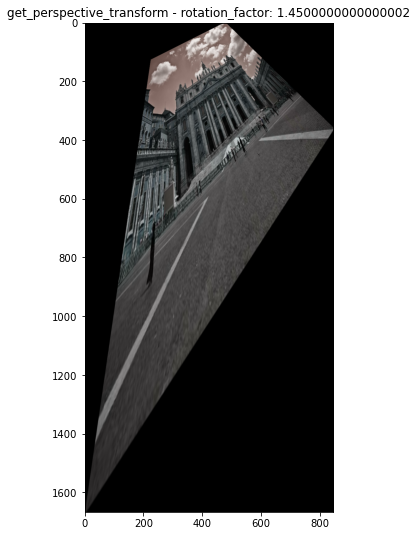

In [1]:
%matplotlib inline
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import math


def make_homogeneous(column_vecs):
    return np.vstack((column_vecs, np.ones(column_vecs.shape[1])))


def get_rotation_matrix(unit_rotation_vector, theta):

    # Rodrigues formula
    # R = I + sin(theta) . K + (1 - cos(theta)).K**2

    K = np.array([
        [0.0, -unit_rotation_vector[2], unit_rotation_vector[1]],
        [unit_rotation_vector[2], 0.0, -unit_rotation_vector[0]],
        [-unit_rotation_vector[1], unit_rotation_vector[0], 0.0],
    ])
    a = np.eye(3)
    b = math.sin(theta) * K
    c = (1.0 - math.cos(theta)) * K @ K

    R = a + b + c
    return R


def get_rectification_rotation(normal, rotation_factor=1.0):

    # now the normals will be "from the camera", "inside" the surfaces
    normal = -normal

    z = np.array([0.0, 0.0, 1.0])

    rotation_vector = np.cross(normal, z)
    rotation_vector_norm = abs_sin_theta = np.linalg.norm(rotation_vector)
    unit_rotation_vector = rotation_vector / rotation_vector_norm
    theta = math.asin(abs_sin_theta) * rotation_factor
    print("theta: {}".format(theta * 180 / math.pi))

    R = get_rotation_matrix(unit_rotation_vector, theta)
    det = np.linalg.det(R)
    assert math.fabs(det - 1.0) < 0.0001
    print("R:\n{}".format(R))
    return R


def show_transormation(K, normal):
    
    for t in range(20):
        rotation_factor=0.5 + t * 0.05

        R = get_rectification_rotation(normal, rotation_factor=rotation_factor)
        print("R:\n{}".format(R))

        T, bounding_box = get_perspective_transform(R, K)

        rectified = cv.warpPerspective(img, T, bounding_box)

        plt.figure(figsize=(9, 9))
        plt.title("get_perspective_transform - rotation_factor: {}".format(rotation_factor))
        plt.imshow(rectified)
        plt.show()



def get_perspective_transform(R, K):
    
    scale = 1.0
    
    K_inv = np.linalg.inv(K)

    unscaled = True
    while unscaled:

        coords = np.where(img[:, :, 0] > 0)
        coords = np.array([coords[1], coords[0]])
        coords = make_homogeneous(coords)

        # I really think I need K (even if estimated)
        print("K:\n{},\nR:\n{},\nK_inv: {}".format(K, R, K_inv))
        P = K @ R @ K_inv
        print("original P:\n{}".format(P))
        if scale != 1.0:
            unscaled = False
            #scale = scale * 10
            print("scale: {}".format(scale))
            P[:2, :] *= scale

        new_coords = P @ coords
        new_coords = new_coords / new_coords[2, :]

        min_row = min(new_coords[1])
        max_row = max(new_coords[1])
        min_col = min(new_coords[0])
        max_col = max(new_coords[0])

        dst = np.float32([[min_col, min_row], [min_col, max_row - 1], [max_col - 1, max_row - 1], [max_col - 1, min_row]])
        dst = np.transpose(dst)
        dst = make_homogeneous(dst)

        if unscaled:
            new_bb_size = (max_row - min_row) * (max_col - min_col)
            scale = np.sqrt((coords.shape[1] * 2.0) / new_bb_size)
            if scale == 1.0:
                unscaled = False
                break


    translate_vec_new = (-np.min(dst[0]), -np.min(dst[1]))

    translate_matrix = np.array([
        [1, 0, translate_vec_new[0]],
        [0, 1, translate_vec_new[1]],
        [0, 0, 1],
    ])


    dst = translate_matrix @ dst
    print("scaled P:\n{}".format(P))
    print("translate_matrix:\n{}".format(translate_matrix))
    P = translate_matrix @ P
    print("new P:\n{}".format(P))
    bounding_box = (math.ceil(np.max(dst[0])), math.ceil(np.max(dst[1])))
    print("bounding box: {}".format(bounding_box))
    
    return P, bounding_box
    
img = cv.imread("phototourism/st_peters_square/set_100/images/99261069_5958624644.jpg", None)
plt.figure()
plt.title("Original img")
plt.imshow(img)
plt.show()

K = [[839.76184082,  0.,  516.], 
     [  0.,          839.76184082,  342.], 
     [  0.,          0.,        1.]]


#normal = np.array([-0.1521864, -0.90305215, 0.40166667])
normal = np.array([-0.221, -0.97305215, -0.062])

# rotation around x axis
# y = -0.9
# z = math.sqrt(1.0 - y**2)
# normal = np.array([0.0, y, z])

show_transormation(K, normal)

